<a href="https://colab.research.google.com/github/davidarvai/DIPLOMADOLGOZAT/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import math
import random
import numpy as np
import nibabel as nib
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


base_output_dir = "/content/drive/My Drive/Allamvizsga/OutputCNN"

# Results subfolder: test results and final learning curves
eredmeny_dir = os.path.join(base_output_dir, "Eredmeny")
os.makedirs(eredmeny_dir, exist_ok=True)

# ModelSave subfolder: saved model states (checkpoint, training log, training state)
modelsave_dir = os.path.join(base_output_dir, "ModelSave")
os.makedirs(modelsave_dir, exist_ok=True)

# File paths in the ModelSave subfolder
checkpoint_path = os.path.join(modelsave_dir, "model_checkpoint.weights.h5")
csv_logger_path = os.path.join(modelsave_dir, "training_log.csv")
training_state_path = os.path.join(modelsave_dir, "training_state.txt")
all_training_log_path = os.path.join(modelsave_dir, "all_training_log.csv")

# Previous helper functions
def get_custom_confusion_matrix(tumor_type, tn, fp, fn, tp):
    if tumor_type == "Whole Tumor":
        custom_matrix = np.array([[tn, fp, fp, fp],
                                  [fn, tp, tp, tp],
                                  [fn, tp, tp, tp],
                                  [fn, tp, tp, tp]])
    elif tumor_type == "Edema":
        custom_matrix = np.array([[tn, tn, fp, tn],
                                  [tn, tn, fp, tn],
                                  [fn, fn, tp, fn],
                                  [tn, tn, fp, tn]])
    elif tumor_type == "Tumor Core":
        custom_matrix = np.array([[tn, fp, tn, fp],
                                  [fn, tp, fn, tp],
                                  [tn, fp, tn, fp],
                                  [fn, tp, fn, tp]])
    elif tumor_type == "Enhancing Core":
        custom_matrix = np.array([[tn, tn, tn, fp],
                                  [tn, tn, tn, fp],
                                  [tn, tn, tn, fp],
                                  [fn, fn, fn, tp]])
    else:
        custom_matrix = None
    return custom_matrix

def compute_confusion(gt_mask, pred_mask):
    tn = np.sum((gt_mask == False) & (pred_mask == False))
    tp = np.sum((gt_mask == True)  & (pred_mask == True))
    fp = np.sum((gt_mask == False) & (pred_mask == True))
    fn = np.sum((gt_mask == True)  & (pred_mask == False))
    return tn, fp, fn, tp

def compute_metrics(tn, fp, fn, tp):
    TPR = tp / (tp + fn) if (tp + fn) > 0 else 0
    TNR = tn / (tn + fp) if (tn + fp) > 0 else 0
    PPV = tp / (tp + fp) if (tp + fp) > 0 else 0
    NPV = tn / (tn + fn) if (tn + fn) > 0 else 0
    ACC = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    DS  = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
    return TPR, TNR, PPV, NPV, ACC, DS

def remap_segmentation(seg):
    seg_new = np.copy(seg)
    seg_new[seg == 4] = 3
    return seg_new

def load_subject_data(subject_path):
    files = os.listdir(subject_path)
    subject_data = {}
    for file in files:
        if file.endswith('.nii') or file.endswith('.nii.gz'):
            lower = file.lower()
            if 'seg' in lower:
                subject_data['seg'] = os.path.join(subject_path, file)
            else:
                for mod in ['t1', 't1ce', 't2', 'flair']:
                    if mod in lower:
                        subject_data[mod] = os.path.join(subject_path, file)
    return subject_data

def normalize_volume(vol):
    vol = vol.astype(np.float32)
    vol = (vol - np.min(vol)) / (np.max(vol) - np.min(vol) + 1e-8)
    return vol

# New data generator for 2D slices
class SliceDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, subject_dirs, batch_size=8, slice_axis=2, include_bg_ratio=0.3, shuffle=True):
        """
        subject_dirs: lista az egyes páciens mappák abszolút elérési útjával
        """
        self.subject_dirs = subject_dirs
        self.batch_size = batch_size
        self.slice_axis = slice_axis
        self.include_bg_ratio = include_bg_ratio
        self.shuffle = shuffle
        self.all_slices = []
        for subject in self.subject_dirs:
            data_files = load_subject_data(subject)
            if 'seg' not in data_files:
                continue
            seg = nib.load(data_files['seg']).get_fdata()
            D = seg.shape[self.slice_axis]
            for i in range(D):
                slice_img = seg[:, :, i]
                if np.sum(slice_img > 0) > 0.01 * slice_img.size or random.random() < self.include_bg_ratio:
                    self.all_slices.append((subject, i))
        if self.shuffle:
            random.shuffle(self.all_slices)

    def __len__(self):
        return math.ceil(len(self.all_slices) / self.batch_size)

    def __getitem__(self, idx):
        batch_indices = self.all_slices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_batch = []
        Y_batch = []
        for subject, slice_idx in batch_indices:
            data_files = load_subject_data(subject)
            modality_imgs = []
            for mod in ['t1', 't1ce', 't2', 'flair']:
                img = nib.load(data_files[mod]).get_fdata()
                modality_imgs.append(normalize_volume(img))
            X_vol = np.stack(modality_imgs, axis=-1)
            seg = nib.load(data_files['seg']).get_fdata()
            seg = remap_segmentation(seg)
            img_slice = X_vol[:, :, slice_idx, :]
            seg_slice = seg[:, :, slice_idx]
            X_batch.append(img_slice)
            Y_batch.append(seg_slice)
        return np.array(X_batch), np.array(Y_batch)

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.all_slices)

# Callback for saving the training state
class SaveTrainingStateCallback(tf.keras.callbacks.Callback):
    def __init__(self, training_state_path):
        super(SaveTrainingStateCallback, self).__init__()
        self.training_state_path = training_state_path

    def on_epoch_end(self, epoch, logs=None):
        with open(self.training_state_path, 'w') as f:
            f.write(str(epoch + 1))
        print(f"Training state updated: epoch {epoch+1} saved to {self.training_state_path}")

# New callback for accumulating all episode data into a file
class AccumulateTrainingLogCallback(tf.keras.callbacks.Callback):
    def __init__(self, file_path):
        super(AccumulateTrainingLogCallback, self).__init__()
        self.file_path = file_path
        if not os.path.exists(self.file_path):
            with open(self.file_path, 'w') as f:
                f.write("epoch,loss,accuracy,val_loss,val_accuracy\n")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        with open(self.file_path, 'a') as f:
            f.write(f"{epoch+1},{logs.get('loss')},{logs.get('accuracy')},{logs.get('val_loss')},{logs.get('val_accuracy')}\n")

# Model definition and loss functions
def unet2d_model(input_shape, n_filters=32, n_classes=4):
    inputs = Input(input_shape, name="input_layer")

    # Encoder blokk 1
    c1 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4), name="conv2d")(inputs)
    c1 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4), name="conv2d_1")(c1)
    c1 = Dropout(0.1, name="dropout_c1")(c1)
    p1 = MaxPooling2D((2, 2), name="max_pooling2d")(c1)

    # Encoder blokk 2
    c2 = Conv2D(n_filters * 2, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4), name="conv2d_2")(p1)
    c2 = Conv2D(n_filters * 2, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4), name="conv2d_3")(c2)
    c2 = Dropout(0.1, name="dropout_c2")(c2)
    p2 = MaxPooling2D((2, 2), name="max_pooling2d_1")(c2)

    # Bottleneck
    c3 = Conv2D(n_filters * 4, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4), name="conv2d_4")(p2)
    c3 = Conv2D(n_filters * 4, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4), name="conv2d_5")(c3)
    c3 = Dropout(0.2, name="dropout_c3")(c3)

    # Decoder blokk 1
    u2 = UpSampling2D((2, 2), name="up_sampling2d")(c3)
    u2 = concatenate([u2, c2], name="concatenate")
    c4 = Conv2D(n_filters * 2, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4), name="conv2d_6")(u2)
    c4 = Conv2D(n_filters * 2, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4), name="conv2d_7")(c4)

    # Decoder blokk 2
    u1 = UpSampling2D((2, 2), name="up_sampling2d_1")(c4)
    u1 = concatenate([u1, c1], name="concatenate_1")
    c5 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4), name="conv2d_8")(u1)
    c5 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_regularizer=l2(1e-4), name="conv2d_9")(c5)

    outputs = Conv2D(n_classes, 1, activation='softmax', name="conv2d_10")(c5)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

def dice_loss_2d(y_true, y_pred, smooth=1e-6):
    if y_true.shape[-1] == 1:
        y_true = tf.squeeze(y_true, axis=-1)
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=4)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(dice)

def combined_loss_2d(y_true, y_pred):
    ce_loss = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    d_loss = dice_loss_2d(y_true, y_pred)
    return ce_loss + d_loss

# Helper function for listing patient folders
def get_subject_dirs(data_dir):
    return sorted([os.path.join(data_dir, d) for d in os.listdir(data_dir)
                   if os.path.isdir(os.path.join(data_dir, d))])

# Main program
if __name__ == "__main__":
    # Data paths
    train_dir = "/content/drive/My Drive/Allamvizsga/Data/Teszt2/Train"
    test_dir = "/content/drive/My Drive/Allamvizsga/Data/Teszt2/Teszt"

    # Collecting patient folders and Train/Val split
    # The dataset is split into 80% for training and 20% for validation.
    all_train_subjects = get_subject_dirs(train_dir)
    if len(all_train_subjects) == 0:
        raise ValueError("Nincsenek betöltött train adatok!")
    train_subjects, val_subjects = train_test_split(all_train_subjects, test_size=0.2, random_state=42)

    # Creating data generators
    batch_size = 8
    train_generator = SliceDataGenerator(train_subjects, batch_size=batch_size, slice_axis=2, include_bg_ratio=0.3, shuffle=True)
    val_generator = SliceDataGenerator(val_subjects, batch_size=batch_size, slice_axis=2, include_bg_ratio=0.3, shuffle=True)

    # Creating the model
    X_sample, _ = train_generator[0]
    input_shape = X_sample.shape[1:]
    model = unet2d_model(input_shape=input_shape, n_filters=32, n_classes=4)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=combined_loss_2d, metrics=['accuracy'])
    model.summary()

    # Loading previous checkpoint, if available
    initial_epoch = 0
    if os.path.exists(checkpoint_path):
        print("Korábbi checkpoint megtalálva, betöltés...")
        model.load_weights(checkpoint_path)
        if os.path.exists(training_state_path):
            with open(training_state_path, 'r') as f:
                try:
                    initial_epoch = int(f.read().strip())
                    print(f"Folytatás az {initial_epoch}. epizódtól.")
                except Exception as e:
                    print("Hiba a training state beolvasása során, újrakezdjük a tréninget.")
                    initial_epoch = 0

  # Defining callbacks: checkpoint, CSV logger, saving training state, and accumulating all data
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        save_freq='epoch',
        verbose=1
    )
    csv_logger = tf.keras.callbacks.CSVLogger(csv_logger_path, append=True)
    training_state_callback = SaveTrainingStateCallback(training_state_path)
    accumulated_log_callback = AccumulateTrainingLogCallback(all_training_log_path)

    # Training the model
    epochs = 20
    History = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        initial_epoch=initial_epoch,
        callbacks=[checkpoint_callback, csv_logger, training_state_callback, accumulated_log_callback]
    )

    # Plotting graphs from all episode data based on the all_training_log.csv file
    full_history = pd.read_csv(all_training_log_path)

    # Loss görbe
    plt.figure(figsize=(8, 6))
    plt.plot(full_history['loss'], label='Train Loss')
    plt.plot(full_history['val_loss'], label='Validation Loss')
    plt.title('Full loss curve')
    plt.xlabel('Epizód')
    plt.ylabel('Loss')
    plt.legend()
    full_loss_path = os.path.join(eredmeny_dir, 'full_loss_curve.png')
    plt.savefig(full_loss_path)
    plt.close()
    print(f"Teljes Loss görbe mentve: {full_loss_path}")

    # Accuracy görbe
    plt.figure(figsize=(8, 6))
    plt.plot(full_history['accuracy'], label='Train Accuracy')
    plt.plot(full_history['val_accuracy'], label='Validation Accuracy')
    plt.title('Full accuracy curve')
    plt.xlabel('Epizód')
    plt.ylabel('Accuracy')
    plt.legend()
    full_acc_path = os.path.join(eredmeny_dir, 'full_accuracy_curve.png')
    plt.savefig(full_acc_path)
    plt.close()
    print(f"Teljes Accuracy görbe mentve: {full_acc_path}")

    # Testing
    test_subjects = get_subject_dirs(test_dir)
    if len(test_subjects) == 0:
        raise ValueError("Nincsenek betöltött teszt adatok!")
    metrics_rows = []
    output_txt_lines = []
    tumor_types = ["Whole Tumor", "Edema", "Tumor Core", "Enhancing Core"]

    for subject in test_subjects:
        data_files = load_subject_data(subject)
        if 'seg' not in data_files:
            continue
        modality_imgs = []
        for mod in ['t1', 't1ce', 't2', 'flair']:
            img = nib.load(data_files[mod]).get_fdata()
            modality_imgs.append(normalize_volume(img))
        X_vol = np.stack(modality_imgs, axis=-1)
        seg = nib.load(data_files['seg']).get_fdata()
        seg = remap_segmentation(seg)
        H, W, D, _ = X_vol.shape
        pred_vol = np.zeros((H, W, D), dtype=np.int32)
        for i in range(D):
            x_slice = X_vol[:, :, i, :]
            x_slice = np.expand_dims(x_slice, axis=0)
            pred_slice = model.predict(x_slice)[0]
            pred_slice = np.argmax(pred_slice, axis=-1)
            pred_vol[:, :, i] = pred_slice

        def get_binary_mask_3d(segmentation, tumor_type):
            if tumor_type == "Whole Tumor":
                return np.isin(segmentation, [1, 2, 3])
            elif tumor_type == "Edema":
                return (segmentation == 2)
            elif tumor_type == "Tumor Core":
                return np.isin(segmentation, [1, 3])
            elif tumor_type == "Enhancing Core":
                return (segmentation == 3)
            else:
                raise ValueError("Ismeretlen tumor típus!")
        for tumor in tumor_types:
            gt_mask = get_binary_mask_3d(seg, tumor)
            pred_mask = get_binary_mask_3d(pred_vol, tumor)
            tn, fp, fn, tp = compute_confusion(gt_mask, pred_mask)
            TPR, TNR, PPV, NPV, ACC, DS = compute_metrics(tn, fp, fn, tp)
            cm = get_custom_confusion_matrix(tumor, tn, fp, fn, tp)

            metrics_rows.append({
                "Name": os.path.basename(subject),
                "TumorType": tumor,
                "TP": tp,
                "TN": tn,
                "FP": fp,
                "FN": fn,
                "TPR": round(TPR, 3),
                "TNR": round(TNR, 3),
                "PPV": round(PPV, 3),
                "NPV": round(NPV, 3),
                "ACC": round(ACC, 3),
                "DS": round(DS, 3)
            })

            txt_block = (f"Mapa neve: {os.path.basename(subject)}\nTumor típus: {tumor}\nKonfúziós mátrix:\n{cm}\n"
                         f"TPR: {round(TPR, 3)}\nTNR: {round(TNR, 3)}\nPPV: {round(PPV, 3)}\nNPV: {round(NPV, 3)}\n"
                         f"ACC: {round(ACC, 3)}\nDS: {round(DS, 3)}\n\n")
            output_txt_lines.append(txt_block)

    metrics_df = pd.DataFrame(metrics_rows, columns=["Name", "TumorType", "TP", "TN", "FP", "FN", "TPR", "TNR", "PPV", "NPV", "ACC", "DS"])
    metrics_csv_path = os.path.join(eredmeny_dir, "metrics_output.csv")
    metrics_df.to_csv(metrics_csv_path, index=False)
    print("A metrics_output.csv fájl elmentve ide:", metrics_csv_path)

    output_txt_path = os.path.join(eredmeny_dir, "output.txt")
    with open(output_txt_path, "w") as f:
        f.write("".join(output_txt_lines))
    print("Az output.txt fájl elmentve ide:", output_txt_path)


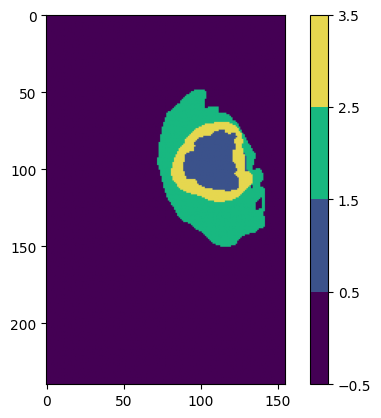

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib as mpl
# Plot a segmantation
some_seg_img = nib.load("/content/drive/My Drive/Allamvizsga/Data/Teszt/Teszt/BraTS20_Training_369/BraTS20_Training_369_seg.nii").get_fdata()

cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

plt.imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
plt.colorbar()

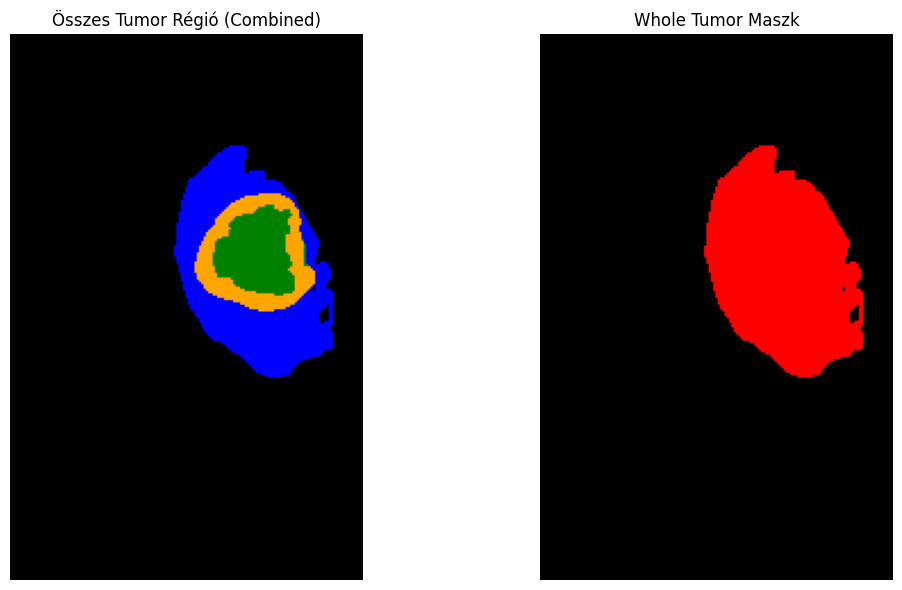

In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib as mpl

# Loading the segmentation
seg_path = "/content/drive/My Drive/Allamvizsga/Data/Teszt/Teszt/BraTS20_Training_369/BraTS20_Training_369_seg.nii"
seg_img = nib.load(seg_path).get_fdata()

# Replacing label 4 with 3
def remap_segmentation(seg):
    seg_new = np.copy(seg)
    seg_new[seg == 4] = 3
    return seg_new

seg_img_cnn = remap_segmentation(seg_img)

# Creating binary masks based on the remapped segmentation (0, 1, 2, 3)
# Whole Tumor (WT) -> (1,2,3)
whole_tumor_mask = np.zeros_like(seg_img_cnn, dtype=np.uint8)
whole_tumor_mask[np.isin(seg_img_cnn, [1, 2, 3])] = 1

# Edema -> (2)
edema_mask = np.zeros_like(seg_img_cnn, dtype=np.uint8)
edema_mask[seg_img_cnn == 2] = 1

# Tumor Core -> (1,3)
tumor_core_mask = np.zeros_like(seg_img_cnn, dtype=np.uint8)
tumor_core_mask[np.isin(seg_img_cnn, [1, 3])] = 1

# Enhancing Core -> (3)
enhancing_core_mask = np.zeros_like(seg_img_cnn, dtype=np.uint8)
enhancing_core_mask[seg_img_cnn == 3] = 1

# Creating a combined label image
combined_labels = np.zeros_like(whole_tumor_mask, dtype=np.uint8)
combined_labels[whole_tumor_mask == 1]   = 1   # Whole Tumor: red
combined_labels[edema_mask == 1]         = 2   # Edema: blue
combined_labels[tumor_core_mask == 1]    = 3   # Tumor Core: green
combined_labels[enhancing_core_mask == 1] = 4  # Enhancing Core: orange


# For the combined image: 0 -> black, 1 -> red, 2 -> blue, 3 -> green, 4 -> orange
cmap_combined = mpl.colors.ListedColormap(['black', 'red', 'blue', 'green', 'orange'])
bounds_combined = [0, 1, 2, 3, 4, 5]
norm_combined = mpl.colors.BoundaryNorm(bounds_combined, cmap_combined.N)

# For the Whole Tumor mask: 0 -> black, 1 -> red
cmap_whole = mpl.colors.ListedColormap(['black', 'red'])
bounds_whole = [-0.5, 0.5, 1.5]
norm_whole = mpl.colors.BoundaryNorm(bounds_whole, cmap_whole.N)

# Displaying images side by side
slice_index = 100  # Selected slice

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# All tumor regions
axs[0].imshow(combined_labels[slice_index, :, :], cmap=cmap_combined, norm=norm_combined)
axs[0].set_title("Összes Tumor Régió (Combined)")
axs[0].axis("off")

# Separate Whole Tumor mask
axs[1].imshow(whole_tumor_mask[slice_index, :, :], cmap=cmap_whole, norm=norm_whole)
axs[1].set_title("Whole Tumor Maszk")
axs[1].axis("off")

plt.tight_layout()
plt.show()


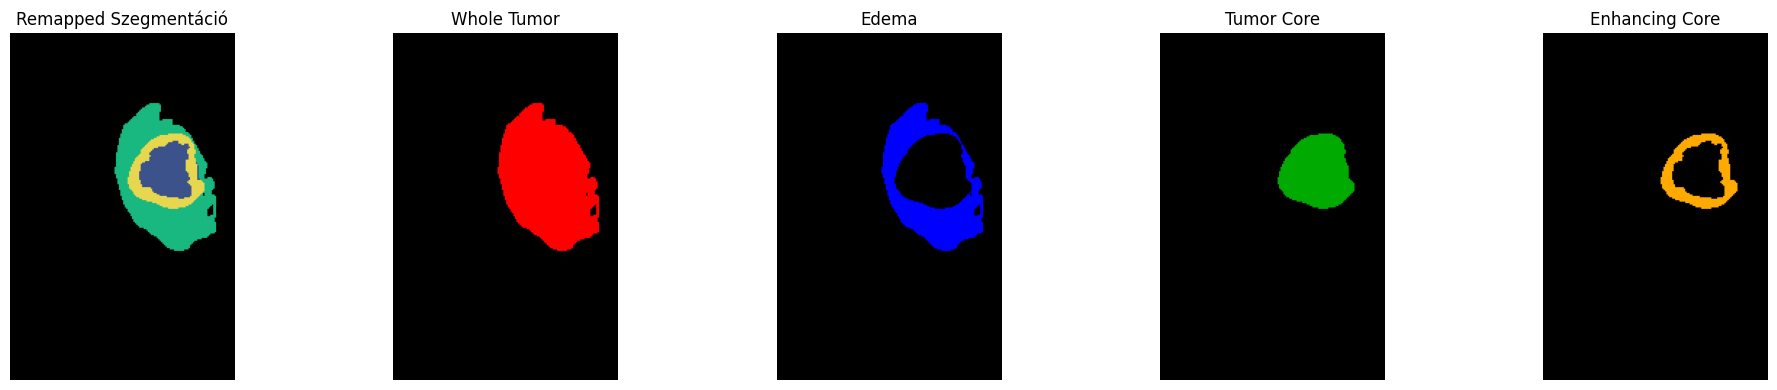

In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib as mpl

# Loading segmentation file
seg_img = nib.load("/content/drive/My Drive/Allamvizsga/Data/Teszt/Teszt/BraTS20_Training_369/BraTS20_Training_369_seg.nii").get_fdata()

# remap_segmentation function: replaces the original label 4 with 3
def remap_segmentation(seg):
    seg_new = np.copy(seg)
    seg_new[seg == 4] = 3
    return seg_new

# Apply the remapping to the segmentation
seg_img_cnn = remap_segmentation(seg_img)

# Visualization settings for the remapped segmentation
cmap_cnn = mpl.colors.ListedColormap(['#000000', '#3b528b', '#18b880', '#e6d74f'])
norm_cnn = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap_cnn.N)

# Creating new class definitions in the form of binary masks
# Whole Tumor (WT) -> (1,2,3)
whole_tumor_mask = np.zeros_like(seg_img_cnn)
whole_tumor_mask[np.isin(seg_img_cnn, [1, 2, 3])] = 1

# Edema -> (2)
edema_mask = np.zeros_like(seg_img_cnn)
edema_mask[seg_img_cnn == 2] = 1

# Tumor Core (TC) -> (1,3)
tumor_core_mask = np.zeros_like(seg_img_cnn)
tumor_core_mask[np.isin(seg_img_cnn, [1, 3])] = 1

# Enhancing Core (EC) -> (3)
enhancing_core_mask = np.zeros_like(seg_img_cnn)
enhancing_core_mask[seg_img_cnn == 3] = 1

# Color maps
# Whole Tumor -> red
cmap_whole = mpl.colors.ListedColormap(['#000000', '#ff0000'])
norm_whole = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5], cmap_whole.N)

# Edema -> blue
cmap_edema = mpl.colors.ListedColormap(['#000000', '#0000ff'])
norm_edema = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5], cmap_edema.N)

# Tumor Core -> green
cmap_core = mpl.colors.ListedColormap(['#000000', '#00aa00'])
norm_core = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5], cmap_core.N)

# Enhancing Core -> orange
cmap_enhancing = mpl.colors.ListedColormap(['#000000', '#ffaa00'])
norm_enhancing = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5], cmap_enhancing.N)

# Visualization
slice_index = 100

fig, axs = plt.subplots(1, 5, figsize=(20, 4))


axs[0].imshow(seg_img_cnn[slice_index, :, :], cmap=cmap_cnn, norm=norm_cnn)
axs[0].set_title("Remapped Szegmentáció")
axs[0].axis("off")

# 4.2) Whole Tumor
axs[1].imshow(whole_tumor_mask[slice_index, :, :], cmap=cmap_whole, norm=norm_whole)
axs[1].set_title("Whole Tumor")
axs[1].axis("off")

# 4.3) Edema
axs[2].imshow(edema_mask[slice_index, :, :], cmap=cmap_edema, norm=norm_edema)
axs[2].set_title("Edema")
axs[2].axis("off")

# 4.4) Tumor Core
axs[3].imshow(tumor_core_mask[slice_index, :, :], cmap=cmap_core, norm=norm_core)
axs[3].set_title("Tumor Core")
axs[3].axis("off")

# 4.5) Enhancing Core
axs[4].imshow(enhancing_core_mask[slice_index, :, :], cmap=cmap_enhancing, norm=norm_enhancing)
axs[4].set_title("Enhancing Core")
axs[4].axis("off")

plt.tight_layout()
plt.show()


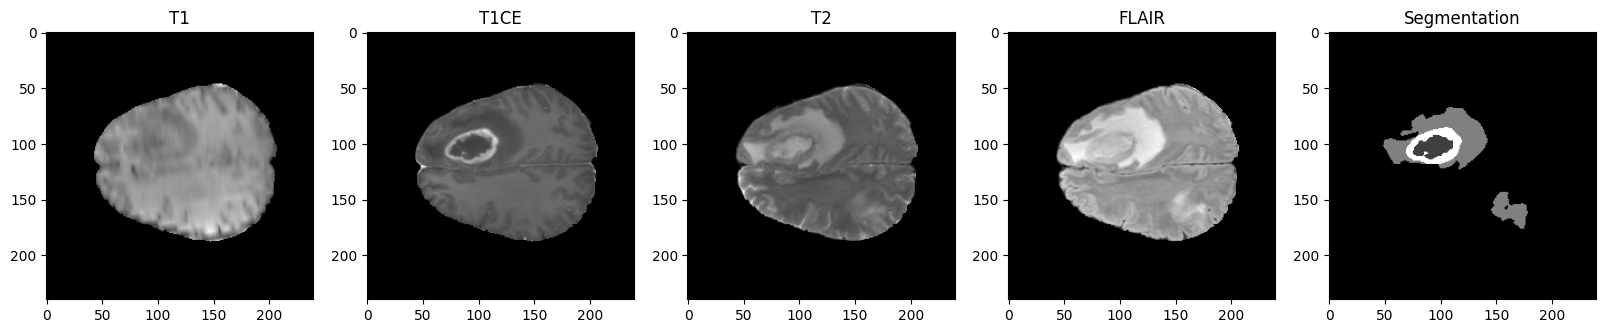

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt

sample_path = '/content/drive/My Drive/Allamvizsga/Data/Teszt/Teszt/BraTS20_Training_369/'

t1_img    = nib.load(sample_path + 'BraTS20_Training_369_t1.nii')
t1ce_img  = nib.load(sample_path + 'BraTS20_Training_369_t1ce.nii')
t2_img    = nib.load(sample_path + 'BraTS20_Training_369_t2.nii')
flair_img = nib.load(sample_path + 'BraTS20_Training_369_flair.nii')
seg_img   = nib.load(sample_path + 'BraTS20_Training_369_seg.nii')

t1_data    = t1_img.get_fdata()
t1ce_data  = t1ce_img.get_fdata()
t2_data    = t2_img.get_fdata()
flair_data = flair_img.get_fdata()
seg_data   = seg_img.get_fdata()

slice_nb = 100
fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs[0].set_title('T1')
axs[1].imshow(t1ce_data[:,:,slice_nb], cmap="gray")
axs[1].set_title('T1CE')
axs[2].imshow(t2_data[:,:,slice_nb], cmap="gray")
axs[2].set_title('T2')
axs[3].imshow(flair_data[:,:,slice_nb], cmap="gray")
axs[3].set_title('FLAIR')
axs[4].imshow(seg_data[:,:,slice_nb], cmap="gray")
axs[4].set_title('Segmentation')
plt.show()
